In [574]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_rel
import pingouin as pg
from statsmodels.stats.multitest import multipletests




In [535]:
# aesthetics
sns.set(style='white', context='paper', font_scale=1.2)

plt.rcParams.update({
   
    'lines.markersize': 1,
    'lines.linewidth': 1,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.figsize': (7, 5),
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': False,
    'axes.edgecolor': 'gray',
    'grid.alpha': 0.2,
    'font.family': 'Arial',
    'axes.linewidth': 0.5,
})


In [536]:
df = pd.read_csv('data/testmybrain_clean_onetar_2March2023.csv')
df.columns

Index(['TN', 'Subject.ID', 'ST', 'RT', 'MT', 'ti', 'ri', 'Group', 'CCW',
       'numtar', 'CN', 'Block', 'FB', 'Hand_raw', 'HandFlip', 'StartTime',
       'Age', 'Handedness', 'education', 'technical', 'rating', 'browsertype',
       'mousetype', 'racialorigin', 'repeat.', 'sex', 'vision', 'NeuroDisease',
       'NeuroDiseaseDescribe', 'screenheight', 'screenwidth', 'endtime',
       'clumsy', 'seedisplay', 'videogames', 'major', 'Sleep', 'ComputerUsage',
       'gameIndex'],
      dtype='object')

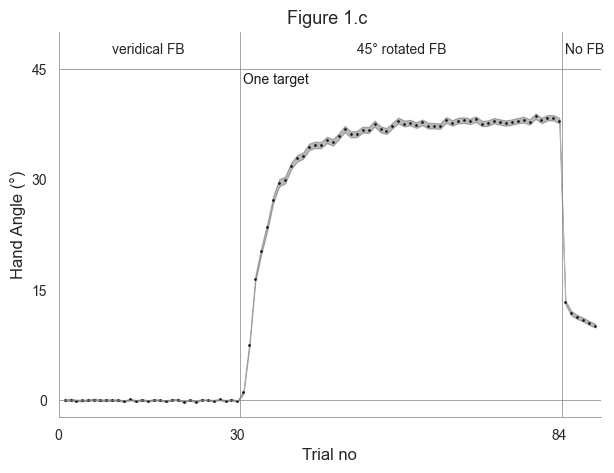

In [537]:
# extract relevant experimental phases (bsl: 1, adap: 2, aftereffect:3)
#df_adap_tmp = df[(df["Block"].isin([1,2,3]))].groupby(['Subject.ID','Block']).head(10)
df_adap_tmp = df[df["Block"].isin([1,2,3])]
# test the new data
df_adap_tmp.iloc[:30][['CN','Block','Subject.ID','HandFlip']]
# calculate the mean over participants for each trial
df_mean = (
    df_adap_tmp.groupby(
    ['Block','CN'])
    .agg(mean_hand = ('HandFlip', 'median'),
        sem_hand = ('HandFlip', lambda x : np.std(x, ddof = 1)/ np.sqrt(len(x)))) 
    #.multiply(180 / np.pi)
    .reset_index())

plt.figure()
plt.plot(df_mean['CN'], df_mean['mean_hand'], marker='o', linestyle = '',markerfacecolor = 'k', markeredgecolor = 'k')
plt.fill_between(df_mean['CN'],
                 df_mean['mean_hand'] - df_mean['sem_hand'],
                 df_mean['mean_hand'] + df_mean['sem_hand'],
                 alpha=0.3, color = 'k')
plt.xlabel('Trial no')
plt.ylabel('Hand Angle (°)')
plt.xlim([0,91])
plt.ylim(top = 50)
plt.xticks([0, 30, 84], ['0', '30', '84'])
plt.yticks([0, 15, 30,45], ['0', '15', '30','45'])
plt.axhline(y= 45, linewidth=0.5, color=[0.5,0.5,0.5])
plt.axhline(linewidth=0.5, color=[0.5,0.5,0.5])
plt.axvline(x = 30.5,linewidth=0.5, color=[0.5,0.5,0.5])
plt.axvline(x = 84.5,linewidth=0.5, color=[0.5,0.5,0.5])
plt.text(15, 47, 'veridical FB', fontsize=10, ha='center')
plt.text(57.5, 47, '45° rotated FB', fontsize=10, ha='center')
plt.text(85, 47, 'No FB', fontsize=10, ha='left')

plt.text(31, 43, 'One target', fontsize=10, color='k',ha='left')

plt.title('Figure 1.c ')
sns.despine(top = True, right = True)
plt.show()




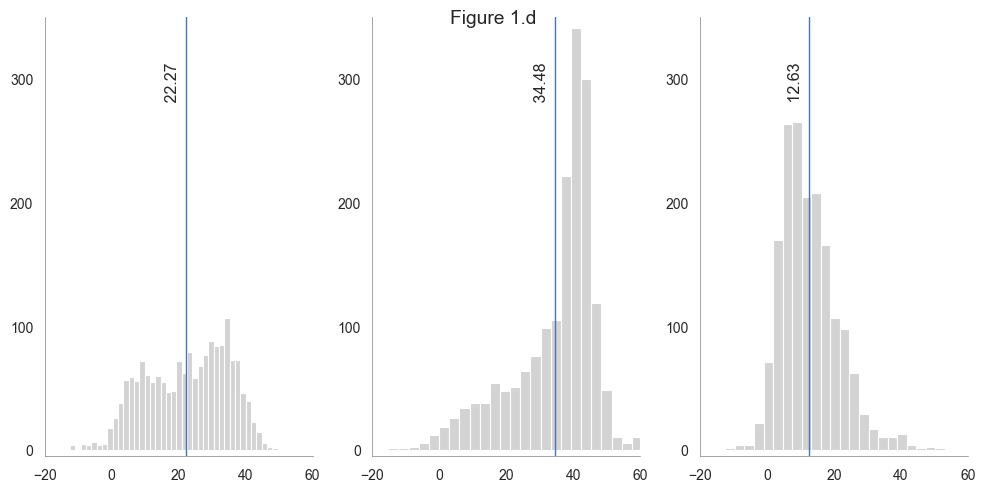

In [538]:
df_adap_epoch = df[(df["Block"].isin([2,3]))] # block 2: adaptation 54trials, block 3: after effect 6 trials
df_early = (df_adap_epoch[(df_adap_epoch['CN'] <= 40) & (df_adap_epoch['Block'] == 2)]
            .groupby(['Subject.ID', 'Block'], as_index = False,sort=False)['HandFlip']
            .mean()
            .reset_index()
            .assign(epoch = 'early'))


df_late = (df_adap_epoch[(df_adap_epoch['CN'] >= 75) & (df_adap_epoch['Block'] == 2)]
            .groupby(['Subject.ID', 'Block'], as_index = False,sort=False)['HandFlip']
            .mean()
            .reset_index()
            .assign(epoch = 'late'))

df_aftereffect = (df_adap_epoch[(df_adap_epoch['Block'] == 3)]
            .groupby(['Subject.ID', 'Block'], as_index = False,sort=False)['HandFlip']
            .mean()
            .reset_index()
            .assign(epoch = 'aftereffect'))

df_epoch = pd.concat([df_early,df_late,df_aftereffect])

epochs = ['early', 'late', 'aftereffect']

fig, ax = plt.subplots(1,3,figsize = (10,5))
for i, epoch in enumerate(epochs):
    data = df_epoch[df_epoch['epoch']== epoch]['HandFlip']
    ax[i].hist(data, bins = 50, color = 'lightgray')
    ax[i].axvline(data.mean())
    ax[i].text(data.mean()-4, 280, "{: .2f}".format(data.mean()),rotation = +90, ha = 'center')

for axis in ax: 
    axis.set_xlim([-20, 60])
    axis.set_ylim([-5, 350])
    axis.set_yticks([0, 100, 200, 300])
    
fig.tight_layout()
fig.suptitle('Figure 1.d')
plt.show()

## Extended Data Fig. 1
Correlation across different phases of adaptation


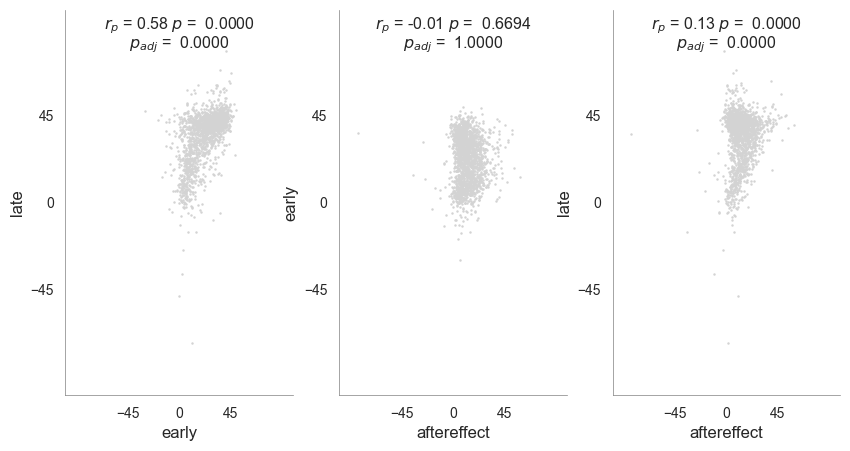

In [600]:
df_epoch = df_epoch.dropna(subset=['HandFlip'])

pairs = [('early', 'late'), ('aftereffect', 'early'), ('aftereffect','late')]

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
p_results = []
for i, phase in enumerate(pairs):
    df_x = df_epoch[df_epoch['epoch'] == phase[0]][['Subject.ID', 'HandFlip']].rename(columns={'HandFlip': 'x'})
    df_y = df_epoch[df_epoch['epoch'] == phase[1]][['Subject.ID', 'HandFlip']].rename(columns={'HandFlip': 'y'})
    
    merged = pd.merge(df_x, df_y, on='Subject.ID').dropna()
    data_x = merged['x']
    data_y = merged['y']
    
    axs[i].scatter(data_x, data_y, marker='o', c='lightgray', edgecolors=None, alpha=0.9)
    axs[i].set_xlabel(phase[0])
    axs[i].set_ylabel(phase[1])
    axs[i].set_xlim([-100, 100])
    axs[i].set_xticks([-45, 0, 45])
    axs[i].set_ylim([-100, 100])
    axs[i].set_yticks([-45, 0, 45])
    
    # Pearson correlation
    r, p = pearsonr(data_x, data_y)
    p_results.append(p)
    axs[i].text(0, 90, f"$r_{{p}}$ = {r:.2f} $p$ = {p: 0.4f}", ha='center')

p_adjusted = multipletests(p_results, method= 'bonferroni')[1]
for i,ax in enumerate(axs):
    axs[i].text(0, 80, f"$p_{{adj}}$ = {p_adjusted[i]: 0.4f}", ha='center')
    
    


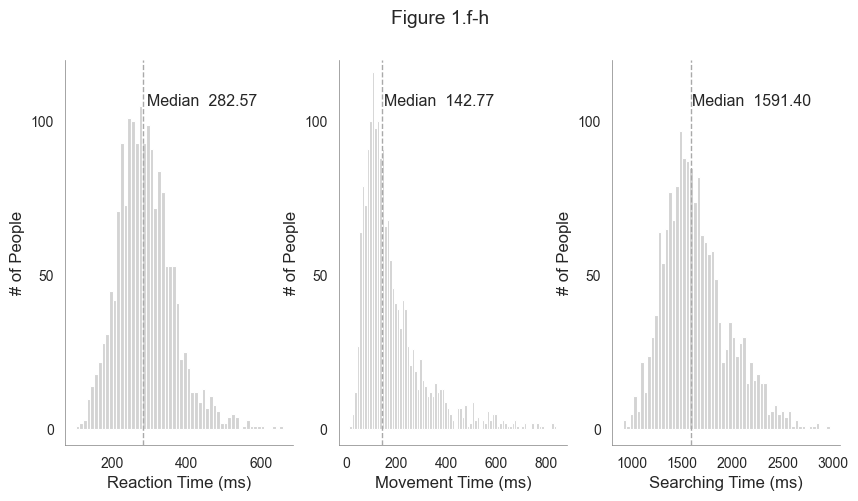

In [410]:
## baseline kinematic parameters (Movement Time, Reaction Time, Search Time)
df_MTRT = (df[(df['Block'] == 1)]
            .groupby(['Subject.ID'], as_index = False, sort=False)[['MT','RT']]
            .mean()
            .reset_index()
            )
#df_ST = (df[(df['Block'] == 1) & (df['ST'] >= 750) & (df['ST'] <= 3000) ]
#            .groupby(['Subject.ID'], as_index = False, sort=False)['ST']
#            .mean()
#            .reset_index()
#            )

# paper calculates ST slightly different than the above. The authors caluclated each subject's mean ST first, 
# then removed entire subjects whose mean ST falls outside [750, 3000]. But the above command, collects first trials within the range and
# calculates the mean, resulting in different median values
# here is paper's approach 

# First: ST mean - for each subject
df_ST_mean = (df[df['Block'] == 1]
                    .groupby('Subject.ID', as_index=False)['ST']
                    .mean())

# Second: subject-wise mean ST (750-3000 ms) 
df_ST = df_ST_mean[(df_ST_mean['ST'] >= 750) & 
                                  (df_ST_unfiltered['ST'] <= 3000)] 

df_kin = pd.merge(df_MTRT,df_ST, on = 'Subject.ID',how = 'inner')

variables = ['RT','MT','ST']
xlabel = ['Reaction Time (ms)','Movement Time (ms)','Searching Time (ms)']
binwidths = [10, 10, 35]
fig, ax = plt.subplots(1,3,figsize = (10,5))
for i, var in enumerate(variables):
    data = df_kin[var]
    # match binwidth with paper binwidth = 10
    bins = np.arange(data.min(), data.max() + binwidths[i], binwidths[i]) 
    median_val = data.median()
    ax[i].hist(data, bins = bins, color='lightgrey', edgecolor= None)
    ax[i].text(median_val+10, 105, f"Median {median_val: .2f}",rotation = 0, ha = 'left')
    ax[i].axvline(median_val, linestyle='dashed', color='darkgrey', linewidth=1)
    ax[i].set_xlabel(xlabel[i])
    ax[i].set_ylabel('# of People')
    ax[i].set_ylim(0, 120)
    ax[i].set_yticks([0, 50, 100])
    
for axis in ax: 
    #axis.set_xlim([-20, 60])
    axis.set_ylim([-5, 120])
    axis.set_yticks([0, 50, 100])
    
fig.suptitle('Figure 1.f-h')
plt.show()

# Figure 1.e (correlation between hand angle on odd and even trials)


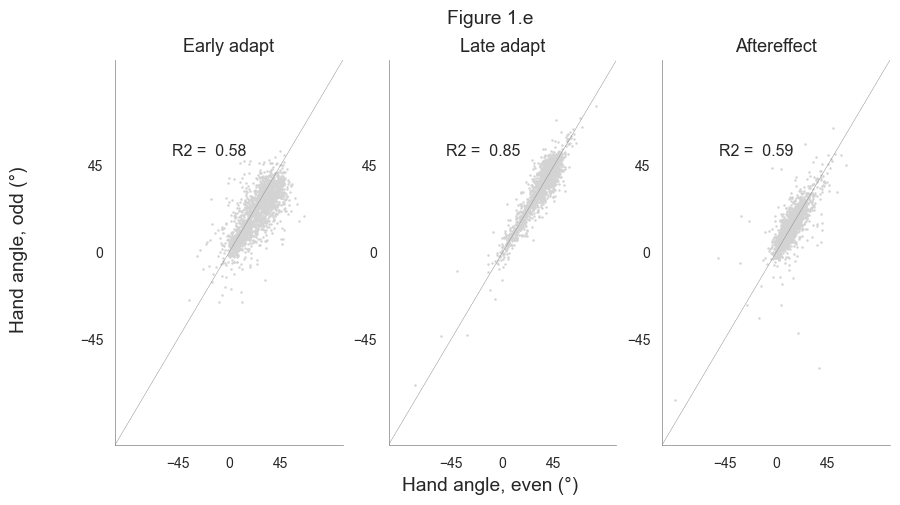

         R2       T_val  p_val        epoch
0  0.575487   48.637329    0.0        early
1  0.852427  100.397344    0.0         late
2  0.594055   50.489809    0.0  aftereffect


In [532]:
df_adap_epoch.columns
# add additional column to define odd and even

df_adap_epoch.loc[:, 'trial_type'] = df_adap_epoch['CN'] % 2
df_early = (df_adap_epoch[(df_adap_epoch['CN'] <= 40) & (df_adap_epoch['Block'] == 2) ]
           .groupby(['Subject.ID','Block', 'trial_type'], sort = False)['HandFlip']
           .mean()
           .reset_index()
           .assign(epoch = 'early'))


df_late = (df_adap_epoch[(df_adap_epoch['CN'] >= 75) & (df_adap_epoch['Block'] == 2) ]
           .groupby(['Subject.ID','Block', 'trial_type'], sort = False)['HandFlip']
           .mean()
           .reset_index()
           .assign(epoch = 'late'))


df_aftereffect = (df_adap_epoch[(df_adap_epoch['Block'] == 3)]
            .groupby(['Subject.ID', 'Block', 'trial_type'], sort=False)['HandFlip']
            .mean()
            .reset_index()
            .assign(epoch = 'aftereffect'))

df_epoch = pd.concat([df_early,df_late,df_aftereffect])
fig, axs = plt.subplots(1,3, figsize = (10,5))

epochs = ['early','late','aftereffect']
labels = ['Early adapt','Late adapt','Aftereffect']
# create a dataframe to store stats
stat_df = []

for i, epoch in enumerate(epochs):
    data_x = df_epoch[(df_epoch['epoch'] == epoch) & (df_epoch['trial_type'] == 0)] # 0 even
    data_y = df_epoch[(df_epoch['epoch'] == epoch) & (df_epoch['trial_type'] == 1)] # odd
    merged = pd.merge(data_x, data_y, on = ['Subject.ID', 'Block', 'epoch'], suffixes = ('_even','_odd'))
    merged = merged.dropna(subset=['HandFlip_even', 'HandFlip_odd'])
    axs[i].scatter(merged['HandFlip_even'], merged['HandFlip_odd'], marker = 'o', c = 'lightgray', edgecolors = None, alpha = 0.9)
    axs[i].set_title(labels[i])
    axs[i].set_xlim([-100, 100])
    axs[i].set_xticks([-45, 0, 45])    
    axs[i].set_ylim([-100, 100])
    axs[i].set_yticks([-45, 0, 45]) 
    # plot identity line
    pt = (-100, -100)
    axs[i].axline(pt, slope=1, color='gray', linewidth = 0.3)
    # run the stats
    r = pearsonr(merged['HandFlip_even'], merged['HandFlip_odd'])
    r2 = r[0] ** 2
    n = len(merged)
    t_val = (r[0] * np.sqrt(n - 2)) / np.sqrt(1 - r[0]**2)
    df = n - 2
    stat_df_temp = pd.DataFrame({'R2': r2, 'T_val': t_val ,'p_val': r[1], 'epoch': [epoch]})
    stat_df.append(stat_df_temp)
    axs[i].text(-50, 50, f"R2 = {r2: .2f}", ha = 'left')
    
stat_df = pd.concat(stat_df, ignore_index=True)

fig.supxlabel('Hand angle, even (°)')    
fig.supylabel('Hand angle, odd (°)')
fig.suptitle('Figure 1.e')
plt.show()

print(stat_df)
